Applicant: Andrew Mulcahy

Role: Senior Data Analyst

# First Exercise: explore the data

Review the unstructured csv files and answer the following questions with code that supports your conclusions:

    Are there any data quality issues present?
    Are there any fields that are challenging to understand?

In [3]:
#First start by importing necessary packages for later use
import pyodbc 
import warnings
import geonamescache
import pandas as pd
import matplotlib.pyplot as plt

#Use this to ignore syntax warnings (run cell twice)
warnings.filterwarnings('ignore')

#Use following to connect to local SQL Server hosted on my desktop
conn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                      "Server=DESKTOP-M9DRD03\SQLEXPRESS;"
                      "Database=fetch_take_home;"
                      "Trusted_Connection=yes;")


cursor = conn.cursor()

In [5]:
#Reading the Users CSV into a dataframe
users = pd.read_csv('C:/Users/admul/Documents/Fetch/USER_TAKEHOME.csv')

In [7]:
#Use the head function to test to make sure data was passed through properly
users.head()

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female


**Start checking for data quality issues within Users csv**

In [10]:
#The following will check for any null values within all columns
print(users.isnull().sum())

#The following will total all null values
print("Total nulls:", users.isnull().sum().sum())

ID                  0
CREATED_DATE        0
BIRTH_DATE       3675
STATE            4812
LANGUAGE        30508
GENDER           5892
dtype: int64
Total nulls: 44887


In [12]:
#The following will replace null values with dummy data
users['BIRTH_DATE'].fillna('1900-01-01 00:00:00.000 Z', inplace=True)
users.fillna('MISSING DATA', inplace=True)

In [14]:
#Checking count of missing values per column after replacing with dummy data
print(users.isnull().sum())

#Checking count of total nulls
print("Total nulls:", users.isnull().sum().sum())

ID              0
CREATED_DATE    0
BIRTH_DATE      0
STATE           0
LANGUAGE        0
GENDER          0
dtype: int64
Total nulls: 0


In [16]:
#Now checking for any duplicated rows
print(users.duplicated().sum())

#Displaying the duplicated rows
print(users[users.duplicated()])

0
Empty DataFrame
Columns: [ID, CREATED_DATE, BIRTH_DATE, STATE, LANGUAGE, GENDER]
Index: []


In [18]:
#Checking data types of the Users dataframe
print(users.dtypes)

ID              object
CREATED_DATE    object
BIRTH_DATE      object
STATE           object
LANGUAGE        object
GENDER          object
dtype: object


In [20]:
#Converting date object to datetime since our table requres this
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'])
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'])

**Create a table in our SQL Database**

In [23]:
#Creating a table in SQL Server for Users
cursor.execute('''
    CREATE TABLE Users (
        id varchar(255),
        created_date datetime,
        birth_date datetime,
        state varchar(255),
        language varchar(255),
        gender varchar(255))
''')
conn.commit()

In [25]:
#Loading data into SQL Server table
for index, row in users.iterrows():
    cursor.execute('INSERT INTO Users (ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER) VALUES (?,?,?,?,?,?)',row.ID, row.CREATED_DATE, row.BIRTH_DATE, row.STATE, row.LANGUAGE, row.GENDER)
conn.commit()

In [26]:
#Writing a query to test if the import was successful
query = 'SELECT TOP 10 * FROM Users'
users_test = pd.read_sql(query, conn)

display(users_test)

,id,created_date,birth_date,state,language,gender
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54,2000-08-11 00:00:00,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55,2001-09-24 04:00:00,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18,1994-10-28 00:00:00,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22,1900-01-01 00:00:00,NC,en,MISSING DATA
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50,1972-03-19 00:00:00,PA,en,female
5,5fe2b6f3ad416a1265c4ab68,2020-12-23 03:18:11,1999-10-27 04:00:00,NY,en,female
6,651210546816bb4d035b1ead,2023-09-25 22:57:24,1983-09-25 22:57:25,FL,es-419,male
7,642831ea3d4434e63c1936fd,2023-04-01 13:30:18,1970-02-16 05:00:00,IN,en,female
8,63a4c9a1b5f32149b9d82f9e,2022-12-22 21:18:25,1982-12-22 05:00:00,NC,en,female
9,63654b21d02459d8a57a2e2c,2022-11-04 17:25:53,1992-05-03 04:00:00,NY,en,non_binary


**Continue looking for data quality issues**

In [28]:
#Using geonames we can get a list of states we expect to see in the table
gc = geonamescache.GeonamesCache()
us_states = gc.get_us_states()

states_list = tuple(us_states.keys())

In [29]:
#Writing a query to check if there are any values not listed in our states list
query = '''
    SELECT state, count(*) as record_count
    FROM Users 
    WHERE state NOT IN {} 
    GROUP BY state
    '''.format(states_list)

In [30]:
#Displaying values not listed in our states list, expecting to see 'MISSING DATA'
not_a_state = pd.read_sql(query, conn)
display(not_a_state)

,state,record_count
0,MISSING DATA,4812
1,PR,1361


In [31]:
#Checking the languages column to see if there are any issues
query = '''
    SELECT language, count(*) as record_count
    FROM Users 
    GROUP BY language
    '''

,language,record_count
0,es-419,6089
1,MISSING DATA,30508
2,en,63403


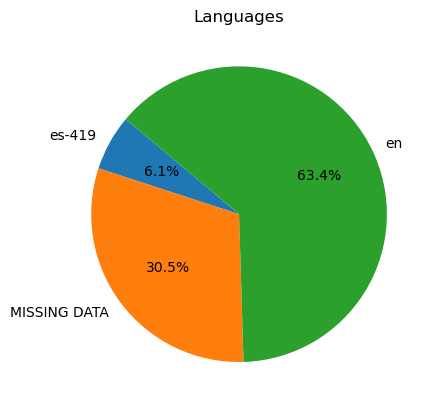

In [32]:
#Displaying the languages in a pie chart to easily see the breakout
languages = pd.read_sql(query, conn)
display(languages)
plt.pie(languages['record_count'], labels=languages['language'], autopct='%1.1f%%', startangle=140)

plt.title('Languages')

plt.show()

In [33]:
#Moving on to the genders column to check for any issues
query = '''
    SELECT gender, count(*) as record_count
    FROM Users 
    GROUP BY gender
    '''

In [34]:
#Display all genders in a quick readable format
genders = pd.read_sql(query, conn)
display(genders)

,gender,record_count
0,unknown,196
1,not_specified,28
2,My gender isn't listed,5
3,non_binary,473
4,MISSING DATA,5892
5,Non-Binary,34
6,prefer_not_to_say,1350
7,male,25829
8,not_listed,180
9,female,64240


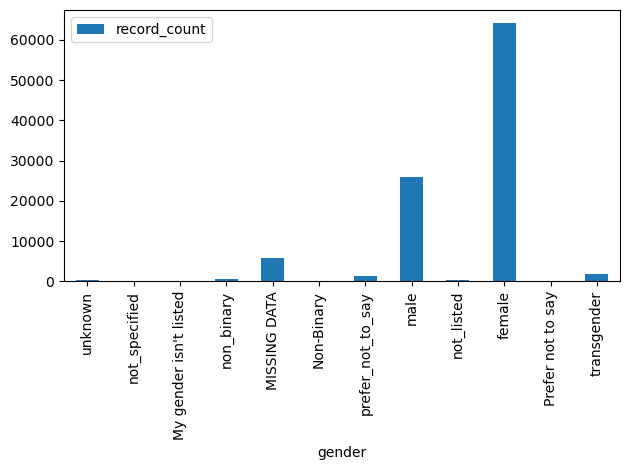

In [35]:
#Using a barchart to visualize the table above
genders.set_index('gender').plot.bar(rot=90)
plt.tight_layout()
plt.show()

In [36]:
#Many genders fall into similar categories, so the following SQL queries can clean that up
query_1 = '''
    UPDATE Users
    SET gender = 'not_listed'
    WHERE gender = 'My gender isn''t listed'
    '''

query_2 = '''
    UPDATE Users
    SET gender = 'prefer_not_to_say' 
    WHERE gender in ('Prefer not to say','not_specified')
    '''

query_3 = '''
    UPDATE Users
    SET gender = 'non_binary' 
    WHERE gender = 'Non-Binary'
    '''

query_4 = '''
    UPDATE Users
    SET gender = 'MISSING DATA' 
    WHERE gender = 'unknown'
    '''


In [37]:
#Executing the queries above
conn.execute(query_1)
conn.execute(query_2)
conn.execute(query_3)
conn.execute(query_4)
conn.commit()

In [38]:
#Checking how genders looks after cleaning
genders = pd.read_sql(query, conn)
display(genders)

,gender,record_count
0,non_binary,507
1,MISSING DATA,6088
2,prefer_not_to_say,1379
3,male,25829
4,not_listed,185
5,female,64240
6,transgender,1772


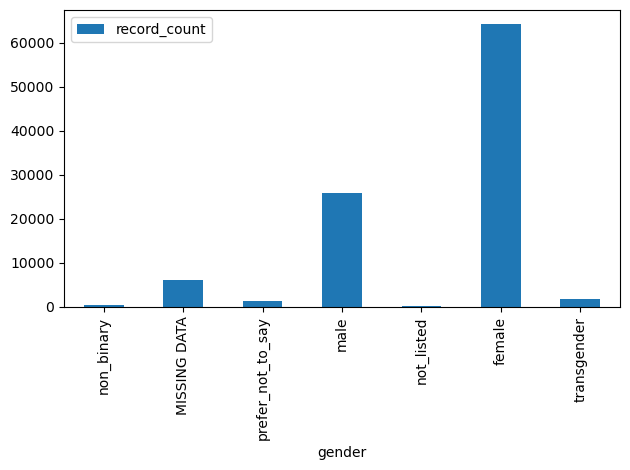

In [39]:
#Applying the same barchart to the table above
genders.set_index('gender').plot.bar(rot=90)
plt.tight_layout()
plt.show()

In [40]:
#Moving on to Birth Dates, I want to see if there are any odd years, for example users under age 5 or over age 100
query = '''
    SELECT ID, CREATED_DATE, BIRTH_DATE, DATEDIFF(YEAR, BIRTH_DATE, CREATED_DATE) AS AGE
    FROM Users
	WHERE BIRTH_DATE <> '1900-01-01'
	GROUP BY ID, CREATED_DATE, BIRTH_DATE
    HAVING (DATEDIFF(YEAR, BIRTH_DATE, CREATED_DATE) > 100 OR DATEDIFF(YEAR, BIRTH_DATE, CREATED_DATE) < 5)
	ORDER BY DATEDIFF(YEAR, BIRTH_DATE, CREATED_DATE) DESC
'''

age = pd.read_sql(query, conn)
display(age)

,ID,CREATED_DATE,BIRTH_DATE,AGE
0,6108a98aa1ffea0b098ba933,2021-08-03 02:27:22,1900-12-08 00:00:00,121
1,624a049c89dfe41b042fe072,2022-04-03 20:33:32,1901-01-01 05:00:00,121
2,62ba454a37e6e08b0775e779,2022-06-28 00:03:22,1901-10-26 06:00:00,121
3,656b3aaa9cb6a4f05dca27c1,2023-12-02 14:09:46,1903-10-08 06:00:00,120
4,61281b41b0fef24601c0d38c,2021-08-26 22:52:49,1901-01-01 05:00:00,120
...,...,...,...,...
65,600cddd039655612b013c58d,2021-01-24 02:39:12,2021-01-23 05:00:00,0
66,6015900b4174b512d037b8c8,2021-01-30 16:57:47,2021-01-30 05:00:00,0
67,5f6bec84d79e8f16ad758543,2020-09-24 00:47:01,2020-02-20 05:00:00,0
68,5f6f9d084d5a671695d3738f,2020-09-26 19:56:57,2020-09-26 05:00:00,0


## Summary of issues with Users

Quality Issues:

1) Many null values in birth date, state, language & gender columns
2) Date is not in a SQL friendly type, I needed to change this to import into my database
3) PR is listed as a state when it does not appear in the list of approved states
4) Gender has many options listed that may fall into the same category as another, I needed to clean this as well
5) There are some users with birth dates that may not make sense, for example users at age 0 or age 121

Challenges:

1) From what I saw, languages could be difficult to understand. It may be easy for some, but using the full word would be best
2) Similar to above, we should add another column that spells the whole word for state for ease of understanding

In [42]:
#Reading the Transaction CSV into a dataframe
tr = pd.read_csv('C:/Users/admul/Documents/Fetch/TRANSACTION_TAKEHOME.csv')

In [43]:
#Use the head function to test to make sure data was passed through properly
tr.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


**Start checking for data quality issues within Transactions csv**

In [45]:
#The following will check for any null values within all columns
print(tr.isnull().sum())

#The following will total all null values
print("Total nulls:", tr.isnull().sum().sum())

RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64
Total nulls: 5762


In [46]:
#Checking to see if a dummy value can be used for NaN BARCODE values
print(tr[tr['BARCODE'].isin([999999999999])])

Empty DataFrame
Columns: [RECEIPT_ID, PURCHASE_DATE, SCAN_DATE, STORE_NAME, USER_ID, BARCODE, FINAL_QUANTITY, FINAL_SALE]
Index: []


In [47]:
#Replacing missing values in BARCODE
tr.fillna(999999999999, inplace=True)

In [48]:
#Checking for duplicate rows
print(tr.duplicated().sum())

#Displaying the duplicated rows
print(tr[tr.duplicated()])

171
                                 RECEIPT_ID PURCHASE_DATE  \
2724   1c12bd8a-c68c-41ee-a26d-294021d3e0b8    2024-09-07   
4192   2acd7e8d-37df-4e51-8ee5-9a9c8c1d9711    2024-09-08   
6572   431fe612-ed55-470e-939c-043ad31f33f3    2024-09-07   
6623   43955b35-6fbc-4909-a4de-1a0de0dc387f    2024-09-06   
7675   4ec870d2-c39f-4a40-bf8a-26a079409b20    2024-09-08   
...                                     ...           ...   
49651  93f45c94-af38-42d4-a3fe-eb9d5b24efbb    2024-09-03   
49660  eee21773-6946-474a-9978-fe0659140973    2024-07-26   
49759  01a70fe0-026f-4bea-9da4-7d13bbf21e9a    2024-09-02   
49911  874a8116-3342-4b4a-9d24-4666e0ab1052    2024-08-31   
49941  e0a60958-e8ef-4fa0-8b1a-5ad01dd64403    2024-07-27   

                       SCAN_DATE            STORE_NAME  \
2724   2024-09-07 15:44:35.241 Z                   CVS   
4192   2024-09-08 11:13:01.935 Z               WALMART   
6572   2024-09-07 16:39:01.409 Z  DOLLAR GENERAL STORE   
6623   2024-09-08 18:32:30.031 

In [49]:
#Dropping duplicate values as the same transaction cannot occur at the same time
tr = tr.drop_duplicates()

In [50]:
#Checking data types of dataframe
print(tr.dtypes)

RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object


In [51]:
#Changing the datatype of BARCODE to int64 as this is what is required for our SQL table
tr['BARCODE'] = tr['BARCODE'].astype('int64')

In [52]:
#Replace negative barcode values
tr['BARCODE'] = tr['BARCODE'].mask(tr['BARCODE'] < 0, 999999999999)

In [53]:
#Converting date object to datetime as this is what is required for our SQL table
tr['PURCHASE_DATE'] = pd.to_datetime(tr['PURCHASE_DATE'])
tr['SCAN_DATE'] = pd.to_datetime(tr['SCAN_DATE'])

In [54]:
#Replacing 'zero' in FINAL_QUANITY with NaN, then dropping these records since this provides no value in our data
tr['FINAL_QUANTITY'].replace('zero', float("NaN"), inplace=True) 
tr = tr.dropna()
tr['FINAL_QUANTITY'] = tr['FINAL_QUANTITY'].astype(float)

In [55]:
#Replacing blanks in FINAL_SALE with NaN, then dropping these records since this provides no value in our data
tr['FINAL_SALE'].replace(' ', float("NaN"), inplace=True)
tr = tr.dropna()
tr['FINAL_SALE'] = tr['FINAL_SALE'].astype(float)

**Create a table in our SQL Database**

In [57]:
#Creating a table in SQL Server for Transactions
cursor.execute('''
    CREATE TABLE Transactions (
        receipt_id varchar(255),
        purchase_date datetime,
        scan_date datetime,
        store_name varchar(255),
        user_id varchar(255),
        barcode bigint,
        quantity numeric,
        sale numeric)
''')
conn.commit()

In [58]:
#Loading data into SQL Server table
for index, row in tr.iterrows():
    cursor.execute('INSERT INTO Transactions (RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,QUANTITY,SALE) VALUES (?,?,?,?,?,?,?,?)',row.RECEIPT_ID, row.PURCHASE_DATE, row.SCAN_DATE, row.STORE_NAME, row.USER_ID, row.BARCODE, row.FINAL_QUANTITY, row.FINAL_SALE)
conn.commit()

## Summary of issues with Transactions

Quality Issues:

1) Many null values present in barcode making joins to Products for theses transactions impossible
2) The field FINAL_QUANTITY has the word 'zero' in it, rather than a number, and this provides no value to to the table so I needed to replace it with NaN then drop those values.
3) FINAL_SALE contained many blanks, also providing no value to the table, so I needed to also convert this to NaN and drop these values for the table to be usable


In [60]:
#Reading the Products CSV into a dataframe
prod = pd.read_csv('C:/Users/admul/Documents/Fetch/PRODUCTS_TAKEHOME.csv')

In [61]:
#Use the head function to test to make sure data was passed through properly
prod.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


**Start checking for data quality issues within Products csv**

In [63]:
#The following will check for any null values within all columns
print(prod.isnull().sum())

#The following will total all null values
print("Total nulls:", prod.isnull().sum().sum())

CATEGORY_1         111
CATEGORY_2        1424
CATEGORY_3       60566
CATEGORY_4      778093
MANUFACTURER    226474
BRAND           226472
BARCODE           4025
dtype: int64
Total nulls: 1297165


In [64]:
#It is acceptable to have categories, manufacturer or brand null, but barcode cannot be null as this is used in our joins
#The following will remove all instances where barcode is null
prod = prod[prod['BARCODE'].notnull()]

In [65]:
#Count of missing values per column after replacing
print(prod.isnull().sum())

#Count of total missing values after replacing
print("Total nulls:", prod.isnull().sum().sum())

CATEGORY_1         111
CATEGORY_2         661
CATEGORY_3       58714
CATEGORY_4      774291
MANUFACTURER    226227
BRAND           226225
BARCODE              0
dtype: int64
Total nulls: 1286229


In [66]:
#Checking for duplicate rows
print(prod.duplicated().sum())

#Displaying the duplicated rows
print(prod[prod.duplicated()])

158
       CATEGORY_1    CATEGORY_2        CATEGORY_3 CATEGORY_4  \
76394      Snacks         Candy               Gum        NaN   
87568      Snacks         Chips            Crisps        NaN   
100470     Snacks         Candy  Confection Candy        NaN   
151285     Snacks         Candy   Chocolate Candy        NaN   
202683     Snacks         Candy   Chocolate Candy        NaN   
...           ...           ...               ...        ...   
823541     Snacks         Candy   Chocolate Candy        NaN   
827242     Snacks         Candy   Chocolate Candy        NaN   
834874     Snacks  Nuts & Seeds           Peanuts        NaN   
838643     Snacks         Candy   Chocolate Candy        NaN   
843215     Snacks         Candy   Chocolate Candy        NaN   

                  MANUFACTURER         BRAND     BARCODE  
76394      THE HERSHEY COMPANY  ICE BREAKERS   3498507.0  
87568             TRADER JOE'S  TRADER JOE'S    952811.0  
100470            LIDL US, LLC          LIDL  2074

In [67]:
#Any duplicated values are not needed as this is just a Product table
prod = prod.drop_duplicates()

In [68]:
#I like to fill missing values with 'Unknown' just so it has a value
prod = prod.fillna('Unknown')

In [69]:
#Checking data types of dataframe
print(prod.dtypes)

CATEGORY_1       object
CATEGORY_2       object
CATEGORY_3       object
CATEGORY_4       object
MANUFACTURER     object
BRAND            object
BARCODE         float64
dtype: object


In [70]:
#I need to assign new datatypes to all columns because the NaN values would mess with the structure of the columns original datatype
prod['CATEGORY_1 '] = prod['CATEGORY_1'].astype('object')
prod['CATEGORY_2'] = prod['CATEGORY_2'].astype('object')
prod['CATEGORY_3'] = prod['CATEGORY_3'].astype('object')
prod['CATEGORY_4'] = prod['CATEGORY_4'].astype('object')
prod['MANUFACTURER'] = prod['MANUFACTURER'].astype('object')
prod['BRAND'] = prod['BRAND'].astype('object')
prod['BARCODE'] = prod['BARCODE'].astype('int64')

**Create a table in our SQL Database**

In [72]:
#Creating a table in SQL Server for Products
cursor.execute('''
    CREATE TABLE Products (
        category_1 varchar(255),
        category_2 varchar(255),
        category_3 varchar(255),
        category_4 varchar(255),
        manufacturer varchar(255),
        brand varchar(255),
        barcode bigint)
    ''')
conn.commit()

In [73]:
#Loading data into SQL Server table
for index, row in prod.iterrows():
    cursor.execute('INSERT INTO Products (CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE) VALUES (?,?,?,?,?,?,?)',row.CATEGORY_1, row.CATEGORY_2, row.CATEGORY_3, row.CATEGORY_4, row.MANUFACTURER, row.BRAND, row.BARCODE)
conn.commit()

## Summary of issues with Products

Quality Issues:

1) There were many null values in barcode, which would be meaningless for this table given the join criteria to the Transactions table, so I was forced to drop those values.
2) There were many duplicated rows which provide no value to this table, so those were also dropped.
3) The missing values created a problem with the data, causing many NaN to create float values within an object column, so all columns needed to go through a data type conversion to be able to comply with SQL loading.


In [75]:
#Testing joining all tables together
tran_user_prod_query = '''
    SELECT *
    FROM Transactions T
    LEFT JOIN Users U ON U.ID = T.USER_ID
    LEFT JOIN Products P ON P.BARCODE = T.BARCODE
'''

tran_user_prod = pd.read_sql(tran_user_prod_query, conn)
display(tran_user_prod)

,receipt_id,purchase_date,scan_date,store_name,user_id,barcode,quantity,sale,id,created_date,...,state,language,gender,category_1,category_2,category_3,category_4,manufacturer,brand,barcode
0,3c7969a2-77ca-47c8-b9af-837756a3af5f,2024-06-22,2024-06-22 18:21:41.637,TOTAL WINE & MORE,6066879b7c25102b3af717e4,71990316006,1.0,24.0,None,NaT,...,None,None,None,Alcohol,Beer,Lager,American Lager,MOLSONCOORS,COORS LIGHT,7.199032e+10
1,c6b87add-1729-4f96-8f73-8030e3598e58,2024-08-31,2024-08-31 20:35:35.020,WALMART,5d155c1ca47c0e517e5688fd,71990316006,1.0,20.0,None,NaT,...,None,None,None,Alcohol,Beer,Lager,American Lager,MOLSONCOORS,COORS LIGHT,7.199032e+10
2,f5c8f7ea-d52c-4ae5-a90d-dacecacad0e9,2024-08-09,2024-08-09 07:40:12.937,WALMART,627be69cabf63218d894fe33,71990316006,1.0,23.0,None,NaT,...,None,None,None,Alcohol,Beer,Lager,American Lager,MOLSONCOORS,COORS LIGHT,7.199032e+10
3,c70529a4-a066-4bff-b2f7-02ee78a2934a,2024-08-25,2024-08-25 14:32:48.047,WALMART,628ac1fb1ec71241a98027b6,71990316006,1.0,23.0,None,NaT,...,None,None,None,Alcohol,Beer,Lager,American Lager,MOLSONCOORS,COORS LIGHT,7.199032e+10
4,93e59840-8f9c-4e6c-a79e-89dce95f8e92,2024-08-16,2024-08-16 22:16:54.817,MEIJER,65c7c0fffe555d15f287f8ed,37000738046,1.0,15.0,None,NaT,...,None,None,None,Health & Wellness,Adult Incontinence,Adult Incontinence Pads,Unknown,PROCTER & GAMBLE,ALWAYS,3.700074e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24849,36163aed-402d-4749-9877-6a4d9343975b,2024-08-10,2024-08-13 12:27:36.970,PUBLIX,5e094f929a28bd129db775bf,940948,1.0,3.0,None,NaT,...,None,None,None,None,None,None,None,None,None,NaN
24850,e0ba8fda-3d34-452c-ae17-440512cddc3b,2024-09-04,2024-09-04 10:37:01.120,SPROUTS FARMERS MARKET,64f113c0c65c76a8489e62c3,940948,2.0,0.0,None,NaT,...,None,None,None,None,None,None,None,None,None,NaN
24851,a34c753e-51a1-4e1d-ae01-afcd02dd0f62,2024-08-12,2024-08-17 09:14:05.407,PUBLIX,5b6707afb912a0207ce0f3b0,940948,1.0,2.0,None,NaT,...,None,None,None,None,None,None,None,None,None,NaN
24852,c60d5209-5b2c-4da0-a5d3-c4889e23e596,2024-08-16,2024-08-20 03:02:50.500,SPROUTS FARMERS MARKET,66513cf77c0469953bf9b9f8,940948,0.0,0.0,None,NaT,...,None,None,None,None,None,None,None,None,None,NaN


**Continue investigating data quality issues on the joined tables**

In [77]:
#Use the following to check how many null values are present after joining tables together
print(tran_user_prod.isnull().sum())

#Count of total nulls
print("Total nulls:", tran_user_prod.isnull().sum().sum())

receipt_id           0
purchase_date        0
scan_date            0
store_name           0
user_id              0
barcode              0
quantity             0
sale                 0
id               24724
created_date     24724
birth_date       24724
state            24724
language         24724
gender           24724
category_1       12487
category_2       12487
category_3       12487
category_4       12487
manufacturer     12487
brand            12487
barcode          12487
dtype: int64
Total nulls: 235753


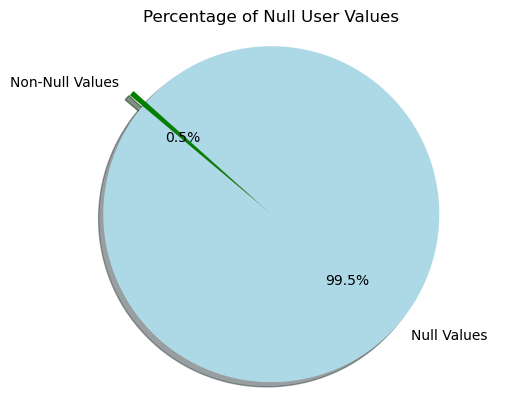

In [78]:
#Taking the number of null user values divided by the total number of values (using receipt_id since there are no nulls) to get a percentage of nulls
null_user_perc = tran_user_prod['id'].isnull().sum() / len(tran_user_prod['receipt_id'].values.flatten())

#Percentage of non null values can be calcuated by taking 1 minus the percentage of nulls
non_null_user_perc = 1 - null_user_perc


#Creating labels, size and colors for the pie chart
labels = ['Null Values', 'Non-Null Values']
sizes = [null_user_perc, non_null_user_perc]
colors = ['lightblue', 'green']
explode = (0.1, 0)  #explode 1st slice

#Create pie chart using matplotlib
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

#Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Percentage of Null User Values')
plt.show()

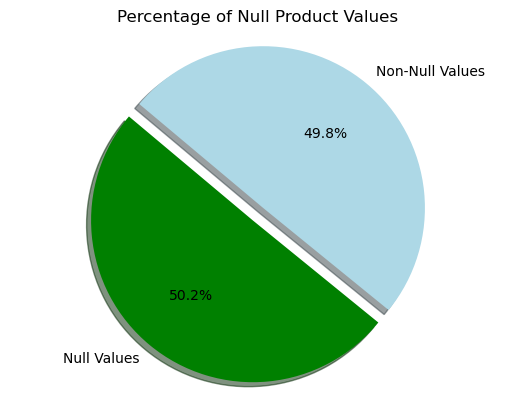

In [79]:
#Performing the same exercise for the Products values
null_prod_perc = tran_user_prod['category_1'].isnull().sum() / len(tran_user_prod['receipt_id'].values.flatten())
non_null_prod_perc = 1 - null_prod_perc


#Creating labels, size and colors for the pie chart
labels = ['Null Values', 'Non-Null Values']
sizes = [null_prod_perc, non_null_prod_perc]
colors = ['green', 'lightblue']
explode = (0.1, 0)  #explode 1st slice

#Create pie chart using matplotlib
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

#Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Percentage of Null Product Values')
plt.show()

## Summary of issues with Joined Tables

Quality Issues:

1) It appears there are many nulls within the Users table and the Products table when joining their keys on the Transactions table. This is especially troublesome for the close-ended & open-ended questions asked, as there is not much data we can now use.

Unfortunately, I will have to proceed with the next exercise knowing there will be massive limitations to the data.



# Second Exercise: provide SQL queries

Answer three of the following questions with at least one question coming from the closed-ended and one from the open-ended question set. Each question should be answered using one query.
Closed-ended questions:

    What are the top 5 brands by receipts scanned among users 21 and over?
    What are the top 5 brands by sales among users that have had their account for at least six months?
    What is the percentage of sales in the Health & Wellness category by generation?

Open-ended questions: for these, make assumptions and clearly state them when answering the question.

    Who are Fetch’s power users?
    Which is the leading brand in the Dips & Salsa category?
    At what percent has Fetch grown year over year?


## What are the top 5 brands by receipts scanned among users 21 and over?

In [84]:
#First I started by creating a CTE, that will give me receipt, brand, and users age where we have values for id and barcode
#Next I pulled from that CTE any users that are 21 or above, and selected the brand and the count of how many times it appears
#When I order by the count descending, it will give me the list of brands by popularity, selecting the Top 5 answers this question
query = '''
WITH sales_by_age AS (
    SELECT 
        receipt_id, 
        brand,
        DATEDIFF(YEAR, BIRTH_DATE, GETDATE()) AS age
    FROM Transactions T
    LEFT JOIN Users U ON U.ID = T.User_id
    LEFT JOIN Products P ON P.barcode = T.barcode
    WHERE id IS NOT NULL
    AND P.barcode IS NOT NULL
)

    SELECT TOP 5 
        brand, 
        COUNT(*) AS receipt_count
    FROM sales_by_age
    WHERE brand <> 'Unknown'
        AND age >= 21
    GROUP BY brand
    ORDER BY COUNT(*) DESC;
'''

#After the query runs, I can put it in a dataframe to display results
age = pd.read_sql(query, conn)
display(age)

,brand,receipt_count
0,NERDS CANDY,3
1,DOVE,3
2,GREAT VALUE,2
3,COCA-COLA,2
4,SOUR PATCH KIDS,2


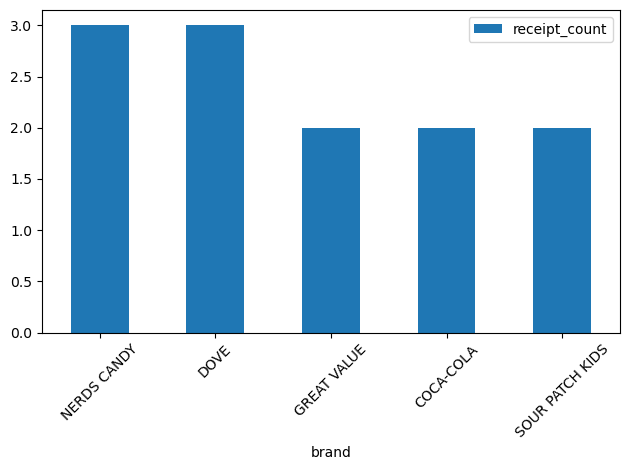

In [85]:
#This dataframe can also be displayed as a bar chart
age.set_index('brand').plot.bar(rot=45)
plt.tight_layout()
plt.show()

What are the top 5 brands by receipts scanned among users 21 and over?

The top 5 brands by receipts scanned among users 21 and over are as follows:

1) Nerds Candy
2) Dove
3) Great Value
4) Coca-Cola
5) Sour Patch Kids

## Which is the leading brand in the Dips & Salsa category?

In [94]:
#I first want to start by defining a function that will tell me which columns a specific value will appear in
def find_col(df, value):
    """
    Finds the column name containing a specific value in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value: The value to search for.

    Returns:
        str or None: The name of the column containing the value, or None if not found.
    """
    for col in df.columns:
        if value in df[col].values:
            return col
    return None

In [99]:
#I can then use the defined funtion to look for 'Dips & Salsa'
column_name = find_col(tran_user_prod, 'Dips & Salsa')

#printing the output will give me the columns I need to use in my SQL query
print(column_name)

category_2


In [104]:
#Now that I know Dips & Salsa appears in category_2, I can use that in my SQL query
#First I create a query that takes total sales and total record count by brand, for category_2 = 'Dips & Salsa'
#Next I will use a rank function to take the ranks of sales and rank of records for each brand
#Selecting the Top 1 will give me what I need

dips_query = '''
SELECT TOP 1 
    total_sale, 
    RANK() OVER(ORDER BY total_sale DESC) AS sales_rank, 
    record_count,
    RANK() OVER(ORDER BY record_count DESC) AS count_rank, 
    brand 
FROM (
    SELECT 
        SUM(quantity * sale) AS total_sale, 
        COUNT(*) AS record_count, 
        brand
    FROM Transactions T
    LEFT JOIN Products P ON P.BARCODE = T.BARCODE
    WHERE category_2 = 'Dips & Salsa'
    GROUP BY brand
) a;
'''

#After the query runs I put the results into a dataframe
dips = pd.read_sql(dips_query, conn)
display(dips)

,total_sale,sales_rank,record_count,count_rank,brand
0,198.0,1,36,1,TOSTITOS


Which is the leading brand in the Dips & Salsa category?

The leading brand in the Dips & Salsa category, both by sales and by receipts, is TOSTITOS.

Again, this assumes that the data we have available is usable for all sales. This is also assuming that the Dips & Salsa category only appears in one column, and is not a part of the missing data.

## What are the top 5 brands by sales among users that have had their account for at least six months?

In [122]:
#First I create a CTE that will give me values I need as well as created age in months, for anything that id and barcode are not null
#I then use that CTE to pull the brand and total sales for created age greater than or equal to 6 months
#If I order by the sum(quantity * sale) descending, this will give me the most popular brands by sales
#I simply need to take the Top 5 to pull what is needed to answer this question

six_months = '''
WITH sales_by_account_create AS (
    SELECT 
        receipt_id, 
        brand,
		quantity,
		sale,
        DATEDIFF(MONTH, CREATED_DATE, GETDATE()) AS created_age
    FROM Transactions T
    LEFT JOIN Users U ON U.ID = T.User_id
    LEFT JOIN Products P ON P.barcode = T.barcode
    WHERE id IS NOT NULL
    AND P.barcode IS NOT NULL
)

    SELECT TOP 5 
        brand, 
        sum(quantity * sale) as total_sale
    FROM sales_by_account_create
    WHERE brand <> 'Unknown'
        AND created_age >= 6
    GROUP BY brand
    ORDER BY sum(quantity * sale) DESC;
'''
#After the query runs, I put this into a dataframe so I can read the results
six = pd.read_sql(six_months, conn)
display(six)

,brand,total_sale
0,CVS,72.0
1,DOVE,31.0
2,TRESEMMÉ,30.0
3,TRIDENT,24.0
4,COORS LIGHT,17.0


What are the top 5 brands by sales among users that have had their account for at least six months?

The top 5 brands by sales among users that have had their account for at least six months are as follows:

1) CVS
2) DOVE
3) TRESEMMÉ
4) TRIDENT
5) COORS LIGHT